  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:01<00:00, 881.96it/s]


0.118


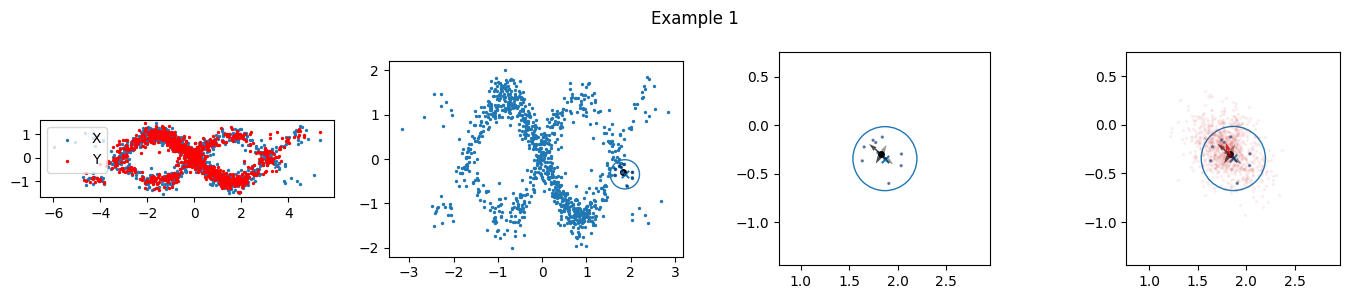

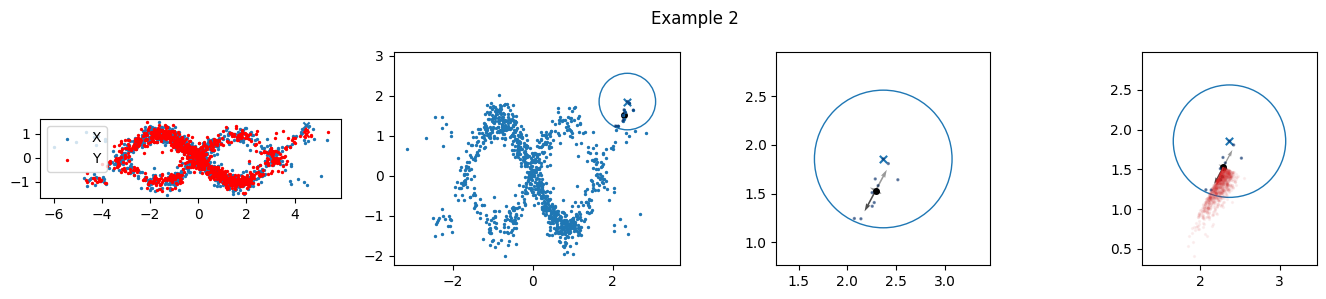

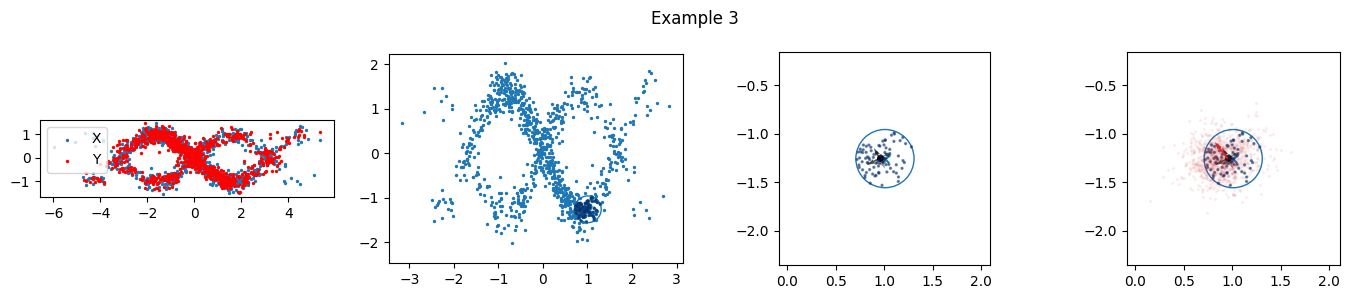

In [3]:
from collections import defaultdict
from typing import Any, Literal
import numpy as np
from scipy.spatial import KDTree, Voronoi, ConvexHull, voronoi_plot_2d
import scipy.stats
import scipy.special
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd
from typing import Callable, Tuple


class ColumnGroup:
    scale = 1.0
    def __init__(self, scale=1.0):
        self.scale = scale

    @staticmethod
    def _pre_shape(X):
        X = np.asarray(X)
        assert len(X.shape) <= 2, X.shape
        shape = X.shape
        while len(X.shape) < 2:
            X = X[:,None]
        return X, shape
    
    def pre_post(self, X:np.ndarray) -> Tuple[np.ndarray, Callable[[np.ndarray], np.ndarray]]:
        raise NotImplementedError
    
    _Categorical:"type[ColumnGroupCategorical]"
    _Continuous:"type[ColumnGroupContinuous]"
    _Discrete:"type[ColumnGroupDiscrete]"
    List:"type[ColumnGroupList]"
    # For simplicity when creating the list:
    @classmethod
    def Cont(cls, idx:list[int]|int, scale=1.0):
        return (idx, cls._Continuous(scale=scale))
    @classmethod
    def Disc(cls, idx:list[int]|int, scale=1.0):
        return (idx, cls._Discrete(scale=scale))
    @classmethod
    def Cat(cls, idx:list[int]|int, scale=1.0, d:int|None=None):
        return (idx, cls._Categorical(scale=scale, d=d))
    
    def __repr__(self):
        return f"{self.__class__.__name__}(scale={self.scale})"
    

class ColumnGroupContinuous(ColumnGroup):
    def pre_post(self, X:np.ndarray):
        X, X_shape = self._pre_shape(X)
        mu, sigma = X.mean(axis=0), X.std(axis=0)
        X = (X - mu) * (self.scale / sigma)

        def post(Y:np.ndarray):
            Y = Y * (sigma / self.scale) + mu
            return Y.reshape(X_shape)
        return X, post
    
class ColumnGroupDiscrete(ColumnGroup):
    def pre_post(self, X:np.ndarray):
        X, post_cont = ColumnGroupContinuous(scale=self.scale).pre_post(X) 
        uniques = np.unique(X, axis=0)
        tree = cKDTree(uniques)
        
        def post(Y:np.ndarray):
            _, idx = tree.query(Y, k=1)
            Y = uniques[idx]
            return post_cont(Y)
        
        return X, post

class ColumnGroupCategorical(ColumnGroup):

    def __init__(self, scale=1.0, d:int|None=None):
        self.scale = scale
        self.d = d
    
    def pre_post(self, X_cat:np.ndarray):
        X_cat, X_cat_shape = self._pre_shape(X_cat)
        assert X_cat.shape[-1] == 1, X_cat.shape
        X = categorical_to_one_hot(X_cat[:,0], d=self.d)
        d = X.shape[1]
        # Read comparison-cat-cont-2.ipynb for details about scaling
        mu = 1 / np.sqrt(d)
        sigma = np.sqrt((d-1)/d)
        X = (X - mu)  * (self.scale / sigma)
        
        def post( Y:np.ndarray):
            # Rescaling commented because the argmax is unaffected with it
            # mu, sigma = self.mu_sigma
            # Y = Y * (sigma / self.scale) + mu
            return np.argmax(Y, axis=1).reshape(X_cat_shape)
        return X, post

ColumnGroup._Categorical = ColumnGroupCategorical
ColumnGroup._Continuous = ColumnGroupContinuous
ColumnGroup._Discrete = ColumnGroupDiscrete


class ColumnGroupList(list[Tuple[np.ndarray, ColumnGroup]]):

    def __init__(self, *groups:Tuple[list[int]|int, ColumnGroup]):
        self[:] = [(np.ravel(idx), col_type) for (idx, col_type) in groups]
        idx = np.concatenate([np.ravel(idx) for idx, _ in self])
        assert set(idx) == set(range(len(idx))), "The continuous, categorical and discrete indices must be unique and cover all columns"
        self.d = len(idx)
    
    def pre_post(self, X: np.ndarray):
        X, X_shape = ColumnGroup._pre_shape(X)
        assert self.d == X.shape[1], (self.d, X.shape[1])
        X_groups = [(idx, col_type.pre_post(X[:,idx])) for idx, col_type in self]

        X_pre = np.concatenate([X_pre for _, (X_pre, _) in X_groups], axis=1)
        
        def post(Y:np.ndarray):
            out = np.ones_like(X) * np.nan
            i = 0
            for idx, (X_pre, post_) in X_groups:
                j = i+X_pre.shape[1]
                out[:, idx] = post_(Y[:, i:j])
                i = j
            assert i==Y.shape[1], (i, Y.shape[1])
            return out.reshape(X_shape)
        
        return X_pre, post

ColumnGroup.List = ColumnGroupList

class CG(ColumnGroup):
    pass

# -----------------------------

def categorical_to_one_hot(X_cat:np.ndarray, d:int|None=None):
    N = len(X_cat)
    assert np.all(np.isclose(X_cat, X_cat.astype(int))), X_cat
    X_cat = X_cat.astype(int)
    if len(X_cat.shape)==2 and X_cat.shape[-1]==1:
        X_cat = X_cat[:,0]
    d_ = d if d is not None else int(X_cat.max() + 1)
    Y = np.zeros((N, d_))
    Y[np.arange(N), X_cat.astype(int)] = 1
    return Y


class Hypersphere:
    '''
    Volume and surface of hard and fuzzy hyperspheres in R^d
    By hard, we refer to a classical hypershpere
    By fuzzy, we refer to an isotropic and unbounded distribution with
    fixed decay function.
        Currently, I am using 1-chi(d).cdf(r) as the decay function,
        because at some point of my reasoning about neighborhoods, I was needing
        probabilities instead of densities at each radius, so I used the chi distribution
        with the formula above, which measures the mass of gaussian noise lying outside the
        hypersphere of d dimensions and radius r.
        I am thinking of changing it to a gaussian decay, but I should check
        if the rest of the code is compatible with a change.
    The fuzzy volume is the total weight of the fuzzy neighborhood
    '''
    
    _cache = {} # class attribute to cache instances
    def __new__(cls, d:int):
        if d in cls._cache:
            return cls._cache[d]
        obj = super().__new__(cls)
        obj._init(d)
        cls._cache[d] = obj
        return obj

    def _init(self, d:int): # if it was called __init__, it would be called even if cached 
        self.d = d
        self.volume1 = np.pi**(d/2) / scipy.special.gamma(1 + d/2)
        self.surface1 = d * self.volume1

        self.fuzzy_volume_sigma1 = self.volume1 * self._fuzzy_volume_factor()
        self.fuzzy_radius1 = self._fuzzy_unitary_radius()
    
    def volume(self, radius:float):
        return self.volume1 * radius**self.d
    
    def surface(self, radius:float):
        return self.surface1 * radius**(self.d-1)
    
    def volume_fuzzy(self, radius:float):
        sigma = self.sigma(radius)
        return self.fuzzy_volume_sigma1 * sigma**self.d

    def random_from_surface(self, size=None):
        'Draw uniformly from the sphere surface'
        shape = () if size is None else tuple(np.ravel(size))
        X =  np.random.normal(0, 1, size=(*shape, self.d))
        X /= np.linalg.norm(X, axis=-1, keepdims=True)
        return X

    def random_hard(self, size=None):
        'Draw uniformly from the volume enclosed by the ellipsoid'
        X = self.random_from_surface(size)
        r = np.random.uniform(0, 1, size=X.shape[:-1])**0.5
        X *= r[:,None]
        return X

    def random_fuzzy(self, size=None):
        'Draw from an (unbounded) multivariate gaussian distribution'
        shape = () if size is None else tuple(np.ravel(size))
        X = np.random.normal(0, 1, size=(*shape, self.d))
        return X * self.fuzzy_radius1
    
    def _fuzzy_unitary_radius(self):
        '''
        Radius of the fuzzy neighborhood in d dimensions
        that has the same total weight (number of elements) as the
        hard neighborhood of radius 1 in d dimensions.
        Here, integral is the integral of hypersphere(r) * (1-chi(d).cdf(r)) for r in [0,oo)
        '''
        return self._fuzzy_volume_factor() ** (-1/self.d)

    def _fuzzy_volume_factor(self):
        d = self.d
        return scipy.special.gamma(1 + (d-1)/2) * 2**(3*d/2 - 1) / np.sqrt(np.pi)

    def _test(self):
        'Test the formulas used in this class'
        self._test_fuzzy_volume()
        self._test_fuzzy_radius()
        self._test_volume()
        return
    
    def _test_fuzzy_volume(self):
        attr = self.fuzzy_volume_sigma1
        prob = lambda r: 1 - scipy.stats.chi(self.d).cdf(r)
        computed, _ = scipy.integrate.quad(lambda r: self.surface(r) * prob(r), 0, np.inf)
        assert np.isclose(attr, computed), (attr, computed)
        return
    
    def _test_fuzzy_radius(self):
        attr = self.volume1
        R = self.fuzzy_radius1
        prob = lambda r: 1 - scipy.stats.chi(self.d).cdf(r/R)
        computed, _ = scipy.integrate.quad(lambda r: self.surface(r) * prob(r), 0, np.inf)
        assert np.isclose(attr, computed), (attr, computed)
        return
    
    def _test_volume(self):
        attr = self.volume1
        computed, _ = scipy.integrate.quad(lambda r: self.surface(r), 0, 1)
        assert np.isclose(attr, computed), (attr, computed)
        return

# for d in range(1, 10):
#     Hypersphere(d)._test()
# print('All tests passed!')


class NotEnoughNeighbors(Exception):
    pass

    
class Neighborhood:
    'Collection of possibly weighted points within a radius around a central point in R^d'

    def __init__(self, center:np.ndarray, radius:float, points:np.ndarray, weights:np.ndarray):
        self.center = center
        self.radius = radius
        self.points = points
        self.weights = weights

class Ellipsoid:
    'Ellipse in n-dimensions, defined by its center (mu), amplitudes (lambdas) and orthogonal directions (matrix V)'

    def __init__(self, mu:np.ndarray, lambdas:np.ndarray, V:np.ndarray|None=None):
        self.mu = mu
        self.lambdas = lambdas
        self.V = V if V is not None else np.eye(len(mu))
        self.d = len(lambdas)
        assert mu.shape == lambdas.shape, (mu.shape, lambdas.shape)
        assert self.V.shape == (len(mu), len(mu)), self.V.shape
        self.orientation:np.ndarray|None = None

    def orient(self, neigh:Neighborhood):
        '''
        Orient the eigenvectors towards the majority of the data points
        and assign a probability (at least 0.5) of not-inverting for random sampling
        '''
        # Project the points onto the ellipsoid to see the direction
        orientation = np.zeros(self.d)
        X = neigh.points - neigh.center
        for i in range(self.d):
            # Count the number of neighbors in the direction of the eigenvector
            dirs = X @ self.V[:,i]
            w_pos = np.sum(neigh.weights[dirs>0] * dirs[dirs>0])
            w_neg = np.sum(neigh.weights[dirs<0] * -dirs[dirs<0]) # type:ignore
            if np.isclose(w_pos + w_neg, 0):
                orientation[i] = 0.5
                continue
            orientation[i] = w_pos / (w_pos + w_neg + 1e-15)
            if orientation[i] < 0.5:
                self.V[:,i] *= -1
                orientation[i] = 1 - orientation[i]
        self.orientation = orientation
    
    
    @classmethod
    def from_neighborhood(cls, neigh:Neighborhood, min_neigh=None, orient=True):
        points, weights = neigh.points, neigh.weights
        n_neigh = np.sum(weights)
        if len(points)<=1 or (min_neigh is not None and n_neigh < min_neigh):
            raise NotEnoughNeighbors
        mu = np.average(points, axis=0, weights=weights)
        cov = np.cov(points.T, aweights=weights)
        try:
            diag, V = np.linalg.eig(cov)
        except np.linalg.LinAlgError:
            raise NotEnoughNeighbors
        diag[np.isclose(diag,0, atol=1e-15)] = 0
        lambdas = np.sqrt(diag)
        if np.all(lambdas==0):
            raise NotEnoughNeighbors
        ell = cls(mu, lambdas, V)
        if orient:
            ell.orient(neigh)
        return ell

    def random(self, fuzzy:bool, size=None):
        return self.random_fuzzy(size) if fuzzy else self.random_hard(size)
    
    def random_hard(self, size=None):
        'Draw uniformly from the volume enclosed by the ellipsoid'
        _N = 1 if size is None else int(np.prod(np.ravel(size)))
        X = Hypersphere(self.d).random_hard((_N, d))
        X *= self.lambdas[None, :]
        if self.orientation is not None:
            sign = 2*(np.random.random(size=X.shape) < self.orientation[None,:]) - 1
            X = np.abs(X) * sign
        for i in range(_N):
            X[i, :] = (self.V @ X[i, :]) + self.mu
        _shape = () if size is None else tuple(np.ravel(size))
        return X.reshape((*_shape, self.d))
    
    def random_fuzzy(self, size=None):
        'Draw from an (unbounded) multivariate gaussian distribution'
        _N = 1 if size is None else int(np.prod(np.ravel(size)))
        X = np.random.normal(0, 1, size=(_N, self.d)) * self.lambdas
        X *= Hypersphere(self.d).fuzzy_radius1
        if self.orientation is not None:
            sign = 2*(np.random.random(size=X.shape) < self.orientation[None,:]) - 1
            X = np.abs(X) * sign
        for i in range(_N):
            X[i, :] = (self.V @ X[i, :]) + self.mu
        _size = () if size is None else tuple(np.ravel(size))
        return X.reshape((*_size, self.d))


class EllipseNeighborhoods:

    def __init__(self, X:np.ndarray, fuzzy=False):
        self.tree = KDTree(X)
        self.is_fuzzy = fuzzy
    
    def ball(self, x:np.ndarray, radius:float, min_neigh=None):
        if self.is_fuzzy:
            return self.fuzzy_ball(x, radius, min_neigh=min_neigh)
        else:
            return self.hard_ball(x, radius, min_neigh=min_neigh)

    def hard_ball(self, x:np.ndarray, radius:float, min_neigh=None):
        idx = self.tree.query_ball_point(x, r=radius, p=2)
        X = self.tree.data
        X, counts = np.unique(X[idx], axis=0, return_counts=True)
        weights = counts
        neigh = Neighborhood(x, radius, X, weights)
        ell = Ellipsoid.from_neighborhood(neigh, min_neigh)
        return neigh, ell

    def fuzzy_ball(self, x:np.ndarray, radius:float, min_neigh=None, alpha=0.95):
        d = len(x)
        radius *= fuzzy_unitary_radius(d)
        ref_dist = scipy.stats.chi(d)
        large_radius = ref_dist.ppf(alpha)
        idx = self.tree.query_ball_point(x, r=large_radius, p=2)
        X = self.tree.data
        X, counts = np.unique(X[idx], axis=0, return_counts=True)
        dists = np.linalg.norm(X-x, axis=1)
        probs = 1-ref_dist.cdf(dists / radius)
        weights = probs*counts
        neigh = Neighborhood(x, radius, X, weights)
        ell = Ellipsoid.from_neighborhood(neigh, min_neigh)
        return neigh, ell
    
    def ball_auto(self, x:np.ndarray, min_radius:float, min_neigh:int):
        f = self.fuzzy_ball if self.is_fuzzy else self.hard_ball
        r = min_radius
        while True:
            try:
                return f(x, r, min_neigh=min_neigh)
            except NotEnoughNeighbors:
                r *= 1.1


class AlgorithmParams:
    def __init__(self,
                 min_neigh_radius=0.1,
                 min_neigh_count=10,
                 min_abs_noise_radius=0,
                 min_rel_noise_radius=0,
                 noise_scale=1,
                 fuzzy_neigh=False,
                 fuzzy_noise=False,):
        self.min_neigh_radius = min_neigh_radius
        self.min_neigh_count = min_neigh_count
        self.min_abs_noise_radius = min_abs_noise_radius
        self.min_rel_noise_radius = min_rel_noise_radius
        self.fuzzy_neigh = fuzzy_neigh
        self.fuzzy_noise = fuzzy_noise
        self.noise_scale = noise_scale


def algorithm(X: np.ndarray, column_types:ColumnGroupList, params:AlgorithmParams, size=None):
    X, post = column_types.pre_post(X)
    N, d = X.shape
    _N = 1 if size is None else int(np.prod(np.ravel(size)))
    Y = np.ones((_N, N, d)) * np.nan
    radii_that_work = []
    # Prepare nearest neighbor search
    neighs = EllipseNeighborhoods(X, fuzzy=params.fuzzy_neigh)
    for i_x in tqdm(range(N)):
        xi = X[i_x]
        r = params.min_neigh_radius
        if i_x > 10:
            r = float(np.quantile(radii_that_work, 0.2))# speed up
        neigh, ell = neighs.ball_auto(xi, r, params.min_neigh_count)
        radii_that_work.append(neigh.radius)
        # Scale the ellipsoid for noise sampling
        ell.lambdas *= params.noise_scale
        min_noise_radius = max(params.min_abs_noise_radius, params.min_rel_noise_radius * r)
        ell.lambdas *= max(1, min_noise_radius/float(np.linalg.norm(ell.lambdas)))
        # Sample a random direction
        Y[:, i_x, :] = ell.random(fuzzy=params.fuzzy_noise, size=_N)
    # Postprocess
    Y = np.stack([post(Y[i, :,:]) for i in range(_N)], axis=0)
    _size = () if size is None else tuple(np.ravel(size))
    return Y.reshape(*_size, *Y.shape[1:])



def algorithm_plot(X: np.ndarray, column_types:CG.List, params:AlgorithmParams, i_x=None, xy=[0,1], axes=None):
    global Xc, Yi
    X, post = column_types.pre_post(X)
    Xc = X
    N, d = X.shape
    # Prepare nearest neighbor search
    neighs = EllipseNeighborhoods(X, fuzzy=params.fuzzy_neigh)
    xi = X[i_x]
    r = params.min_neigh_radius
    neigh, ell = neighs.ball_auto(xi, r, params.min_neigh_count)
    # Scale the ellipsoid for noise sampling
    ell.lambdas *= params.noise_scale
    min_noise_radius = max(params.min_abs_noise_radius, params.min_rel_noise_radius * r)
    ell.lambdas *= max(1, min_noise_radius/float(np.linalg.norm(ell.lambdas)))
    # Sample a random direction
    y = ell.random(fuzzy=params.fuzzy_noise)
    # Sample many for better plotting
    N_samples = 1000
    Yi = ell.random(fuzzy=params.fuzzy_noise, size=N_samples)
    y_mean = np.mean(Yi, axis=0)
    
    def subset_plot(ax:"plt.Axes", show=[]): # type:ignore
        r = neigh.radius
        Nx = neigh.points
        Nxw = neigh.weights
        x = ell.mu
        V = ell.V
        lambdas = ell.lambdas / params.noise_scale
        features = {k:True for k in show}
        if features.get('xi'):
            ax.scatter(xi[None,0], xi[None,1], marker='x', s=28, color='tab:blue')
        if features.get('x'):
            ax.scatter(x[None,0], x[None,1], marker='o', s=16, color='black')
        if features.get('X'):
            ax.scatter(X[:,0], X[:,1], label='X', s=2, color='tab:blue')
        if features.get('circle'):
            circle = plt.Circle(xi, r, fill=False, color='tab:blue') # type: ignore
            ax.add_artist(circle)
            circle_xy = np.random.normal(0, 1, (100,2)) * r
            circle_xy /= np.linalg.norm(circle_xy, axis=1)[:,None]
            circle_xy += xi[None,[0,1]]
            ax.scatter(*circle_xy.T, alpha=0, marker='.', s=2, color='gray')
        if features.get('Nx'):
            ax.scatter(Nx[:,0], Nx[:,1], c=Nxw, vmin=0, label='X', s=2, marker='o', cmap='Blues', alpha=0.5)# type:ignore
        # if features.get('Nxi'):
        #     ax.scatter(xi[0]+Nxi[:,0], xi[1]+Nxi[:,1], label='X', s=5, marker='o', color='tab:blue')
        if features.get('V'):
            for i_v in range(d):
                u = V[:, i_v] * lambdas[i_v]
                ax.quiver(*x[:2], *u[:2], scale=1, scale_units='xy', color='black', alpha=0.7, linewidths=0.5)
                ax.quiver(*x[:2], *-u[:2], scale=1, scale_units='xy', color='black', alpha=0.4, linewidths=0.5)
        if features.get('Yi'):
            ax.scatter(Yi[:,0], Yi[:,1], s=2, c='tab:red', alpha=0.05) 
            # xx = np.zeros_like(Y)
            # xx[:] = x[None,:]
            # ax.quiver(*xx.T, *(Y-x[None,:]).T, scale=1, scale_units='xy', color='tab:red', alpha=0.2)
        if features.get('Yi_contour'):
            kw:Any = dict(fill=False, alpha=0.9, levels=5, linewidths=0.5)
            sns.kdeplot(data=pd.DataFrame(Y), x=0, y=1, ax=ax, color='tab:red', **kw)
        if features.get('y'):
            ax.quiver(*x[:2], *(y-x)[:2],  scale=1, scale_units='xy', color='tab:red', alpha=1)
        if features.get('y_mean'):
            ax.quiver(*x[:2], *(y_mean-x)[:2],  scale=1, scale_units='xy', color='tab:purple', alpha=1)
        ax.set_aspect('equal')
        return

    if axes is None:
        fig, axes = plt.subplots(2, 3, figsize=(5, 5))
        axes = axes.flatten()
    subset_plot(axes[0], show='X xi x circle Nx'.split())
    subset_plot(axes[1], show='xi x circle Nx V'.split())
    # axes[1].set_xlim(axes[0].get_xlim())
    subset_plot(axes[2], show='xi x circle Nx V Yi y'.split())
    return

# np.random.seed(0)
# X = np.random.normal(0, 1, (500,3))
# X[:,0] = 2*X[:,0]
# X[:,2] =  X[:,2] > 0.5
# mask = X[:,2] == 1
# X[mask,1] =  X[mask,1] * 0.1 + np.sin(X[mask,0])
# mask = ~mask
# X[mask,1] =  X[mask,1] * 0.1 - np.sin(X[mask,0])
# column_types = CG.List(
#     CG.Cont([0,1]),
#     CG.Cat([2], scale=0.02, d=2),
# )
# Y = algorithm(X, column_types)
# print(np.mean(X[:,2]!=Y[:,2]))


# for i_x in range(1):
#     fig, axes = plt.subplots(1, 2, figsize=(16, 3))
#     axes = axes.flatten()
#     axes[0].set_aspect('equal')
#     axes[1].set_aspect('equal')
#     axes[0].scatter(X[X[:,2]==0,0], X[X[:,2]==0,1], label='X|0', s=2)
#     axes[0].scatter(X[X[:,2]==1,0], X[X[:,2]==1,1], label='X|1', s=2)
#     axes[1].scatter(Y[Y[:,2]==0,0], Y[Y[:,2]==0,1], label='Y|0', s=2)
#     axes[1].scatter(Y[Y[:,2]==1,0], Y[Y[:,2]==1,1], label='Y|1', s=2)
#     axes[0].legend()
#     axes[1].legend()
#     # algorithm_plot(Xc, i_x=i_x, axes=axes[1:])
#     plt.suptitle(f"Example {i_x+1}")
#     plt.tight_layout()
#     plt.show()

np.random.seed(0)
X = np.random.normal(0, 1, (1000,3))
X[:,0] = 2*X[:,0]
X[:,2] =  X[:,2] > 0.5
mask = X[:,2] == 1
X[mask,1] =  X[mask,1] * 0.2 + np.sin(X[mask,0])
mask = ~mask
X[mask,1] =  X[mask,1] * 0.2 - np.sin(X[mask,0])
column_types = CG.List(
    CG.Cont([0,1]),
    CG.Cat([2], scale=0.1, d=2),
)
params =  AlgorithmParams(min_neigh_radius=0.3, min_neigh_count=10, noise_scale=3, fuzzy_noise=True)
Y = algorithm(X, column_types, params)
print(np.mean(X[:,2]!=Y[:,2]))

N,d = X.shape

min_neigh_count = N**(1/(d+1))
min_neigh_radius = 0.3
for i_x in range(3):
    fig, axes = plt.subplots(1, 4, figsize=(14, 3))
    axes = axes.flatten()
    axes[0].set_aspect('equal')
    axes[0].scatter(X[:,0], X[:,1], label='X', s=2)
    axes[0].scatter(Y[:,0], Y[:,1], label='Y', s=2, c='red')
    axes[0].scatter(X[[i_x],0], X[[i_x],1], marker='x', s=20, c='tab:blue')
    axes[0].scatter(Y[[i_x],0], Y[[i_x],1], marker='x', s=20, c='red')
    axes[0].legend()
    algorithm_plot(X, column_types, params, i_x=i_x, xy=[0,2], axes=axes[1:])
    plt.suptitle(f"Example {i_x+1}")
    plt.tight_layout()
    plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 447.79it/s]


0.32


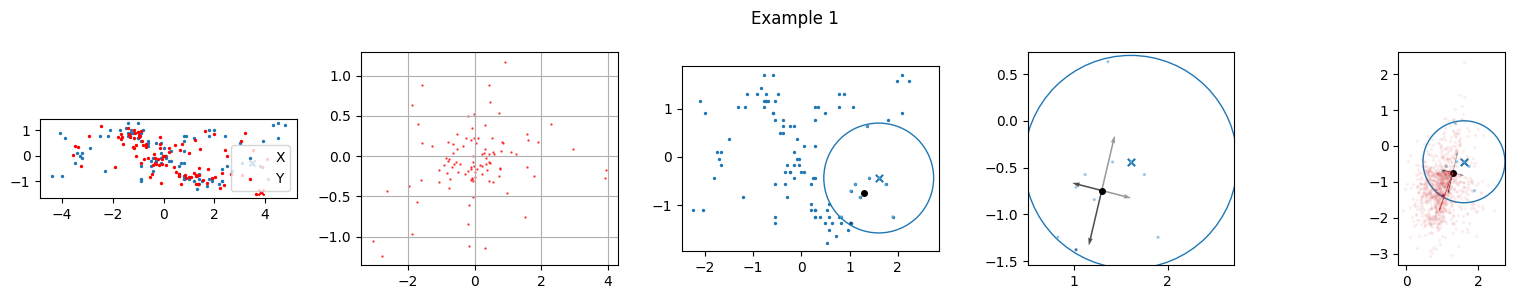

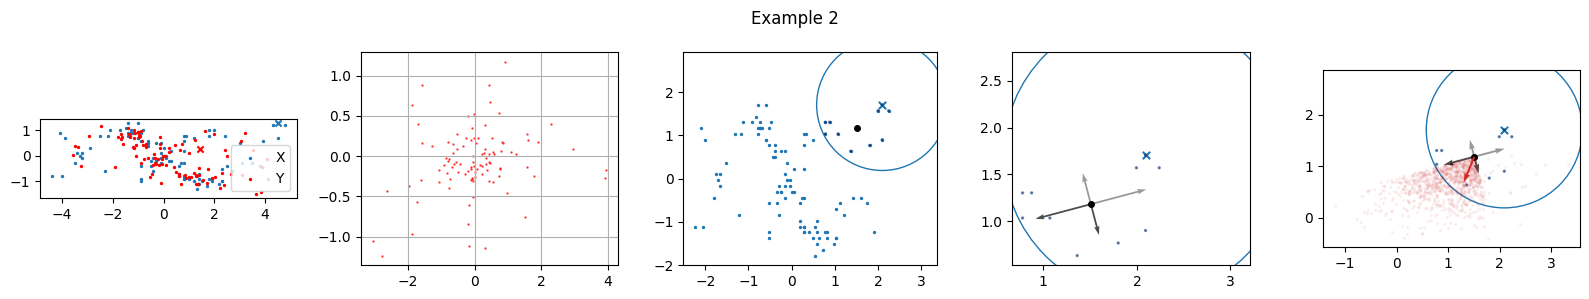

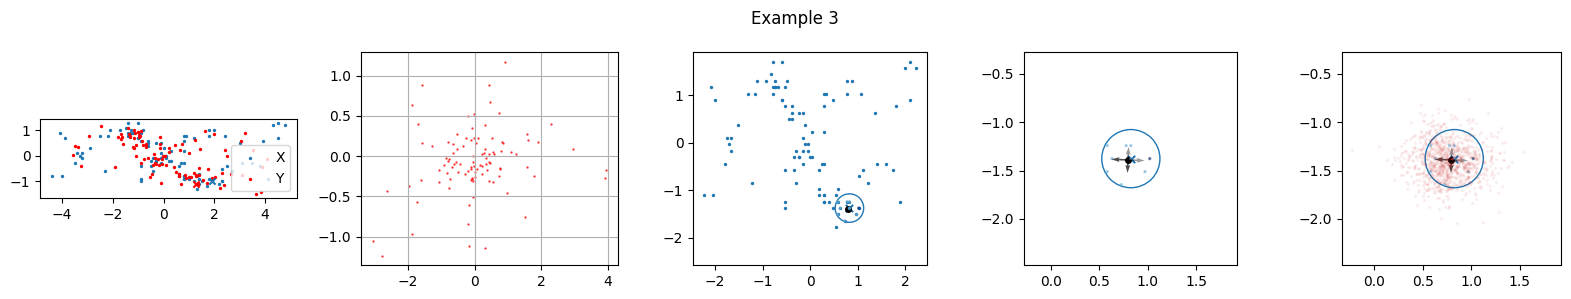

In [109]:

np.random.seed(0)
X = np.random.normal(0, 1, (100,3))
X[:,0] = 2*X[:,0]
X[:,2] =  X[:,2] > 0.5
mask = X[:,2] == 1
X[mask,1] =  X[mask,1] * 0.2 + np.sin(X[mask,0])
mask = ~mask
X[mask,1] =  X[mask,1] * 0.2 - np.sin(X[mask,0])
column_types = CG.List(
    CG.Cont([0,1]),
    CG.Cat([2], scale=0.1, d=2),
)
X[:, :2] = np.round(X[:, :2], 1)
Y = algorithm(X, column_types, params)
print(np.mean(X[:,2]!=Y[:,2]))

N,d =X.shape

min_neigh_count = N**(1/(d+1))
min_neigh_radius = 0.3
for i_x in range(3):
    fig, axes = plt.subplots(1, 5, figsize=(16, 3))
    axes = axes.flatten()
    axes[0].set_aspect('equal')
    axes[0].scatter(X[:,0], X[:,1], label='X', s=2)
    axes[0].scatter(Y[:,0], Y[:,1], label='Y', s=2, c='red')
    axes[0].scatter(X[[i_x],0], X[[i_x],1], marker='x', s=20, c='tab:blue')
    axes[0].scatter(Y[[i_x],0], Y[[i_x],1], marker='x', s=20, c='red')
    axes[0].legend()
    # axes[1].set_aspect('equal')
    # axes[1].quiver(*0*X[:100,:2].T, *(Y-X)[:100, :2].T, color='red', scale_units='xy', scale=1, alpha=0.7)
    axes[1].scatter(*(Y-X)[:100, :2].T, color='red', marker='.', s=2, alpha=0.7)
    axes[1].grid()
    
    algorithm_plot(X, column_types, params, i_x=i_x, xy=[1,2], axes=axes[2:])
    plt.suptitle(f"Example {i_x+1}")
    plt.tight_layout()
    plt.show()

In [96]:

# fig, axes = plt.subplots(1, 2, figsize=(16, 3))
# axes = axes.flatten()
# axes[0].set_aspect('equal')
# axes[1].set_aspect('equal')
# axes[0].scatter(Xc[X[:,2]==0,0], Xc[X[:,2]==0,1], label='Xc|0', s=2)
# axes[0].scatter(Xc[X[:,2]==1,0], Xc[X[:,2]==1,1], label='Xc|1', s=2)
# plt.show()

# np.random.seed(0)
# X = np.random.normal(0, 1, (500,3))
# X[:,0] = 2*X[:,0]
# X[:,2] =  X[:,2] > 0.5
# mask = X[:,2] == 1
# X[mask,1] =  X[mask,1] * 0.1 + np.sin(X[mask,0])
# mask = ~mask
# X[mask,1] =  X[mask,1] * 0.1 - np.sin(X[mask,0])
# X = np.round(X)
# X[:,:2] += 0.1
# column_types = CG.List(CG.Cat(2), CG.Disc([0,1]))
# Y = algorithm(X, column_types)
# print(np.mean(X[:,2]!=Y[:,2]))

# for i_x in range(1):
#     fig, axes = plt.subplots(1, 2, figsize=(16, 3))
#     axes = axes.flatten()
#     axes[0].set_aspect('equal')
#     axes[1].set_aspect('equal')
#     noisy = lambda X: X+np.random.normal(0,1,X.shape)*1e-1
#     axes[0].scatter(noisy(X[X[:,2]==0,0]), noisy(X[X[:,2]==0,1]), label='X|0', s=2)
#     axes[0].scatter(noisy(X[X[:,2]==1,0]), noisy(X[X[:,2]==1,1]), label='X|1', s=2)
#     axes[1].scatter(noisy(Y[Y[:,2]==0,0]), noisy(Y[Y[:,2]==0,1]), label='Y|0', s=2)
#     axes[1].scatter(noisy(Y[Y[:,2]==1,0]), noisy(Y[Y[:,2]==1,1]), label='Y|1', s=2)
#     axes[0].legend()
#     axes[1].legend()
#     # algorithm_plot(Xc, i_x=i_x, axes=axes[1:])
#     plt.suptitle(f"Example {i_x+1}")
#     plt.tight_layout()
#     plt.show()
